In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from helpFunctions import *
import os
import warnings
warnings.filterwarnings('ignore')
%pylab inline
%load_ext autoreload
%autoreload 2
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.rcParams.update({'font.size': 12})
years, data, varNamesOverYears, varNamesOverYearsPlus = loadData()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [5]:
# important variables
'''
    2002-2022 quarterly data
    "TOTAL ASSETS",
    "TOTAL EQUITY CAPITAL",
    "TOTAL LIABILITIES AND MINORITY INTEREST",
    "TOTAL DEPOSITS",
    "FEDERAL FUNDS SOLD", # short term borrowing
    "FEDERAL FUNDS PURCHASED IN DOMESTIC OFFICES", # short term lending
'''
importantVars = ["TOTAL ASSETS",
    "TOTAL EQUITY CAPITAL",
    "TOTAL LIABILITIES AND MINORITY INTEREST",
    "TOTAL DEPOSITS",
    "FEDERAL FUNDS SOLD",
    "FEDERAL FUNDS PURCHASED IN DOMESTIC OFFICES"]
names = ["bank", "date", "assets", "equity", "liabilities", "deposit", "lending", "borrowing"]
    

In [6]:
# process all important variables in one big table
varTable = pd.DataFrame()
for year in years[1:]:
    df = pd.DataFrame()
    for var in importantVars:
        _, d = call([var], year, data = data, varNamesOverYears=varNamesOverYearsPlus)
        if df.size == 0:
            df = d
        else:
            df[var] = d[var]
    if varTable.size == 0:
        varTable = df
    varTable = pd.concat([varTable, df], axis = 0)
varTable.columns = names
varTable['date'] = pd.to_datetime(varTable['date'])

# clean some data points 
varTable = varTable[(varTable['assets'] >0) & 
                    (varTable['equity'] >0) & 
                    (varTable['liabilities'] >0) & 
                    (varTable['deposit'] >=0) & 
                    (varTable['lending'] >=0) & 
                    (varTable['borrowing'] >=0)]
varTable.shape

(601433, 8)

In [7]:
import statsmodels.formula.api as smf
model = smf.ols("lending.div(assets) ~ equity.div(assets) + liabilities.div(assets) + deposit.div(assets)", data=varTable).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     lending.div(assets)   R-squared:                       0.038
Model:                             OLS   Adj. R-squared:                  0.038
Method:                  Least Squares   F-statistic:                     7818.
Date:                 Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                         16:53:43   Log-Likelihood:             8.4473e+05
No. Observations:               601433   AIC:                        -1.689e+06
Df Residuals:                   601429   BIC:                        -1.689e+06
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

In [8]:
model = smf.ols("borrowing.div(assets) ~ equity.div(assets) + liabilities.div(assets) + deposit.div(assets)", data=varTable).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     borrowing.div(assets)   R-squared:                       0.137
Model:                               OLS   Adj. R-squared:                  0.137
Method:                    Least Squares   F-statistic:                 3.170e+04
Date:                   Mon, 16 Jan 2023   Prob (F-statistic):               0.00
Time:                           16:53:44   Log-Likelihood:             1.3830e+06
No. Observations:                 601433   AIC:                        -2.766e+06
Df Residuals:                     601429   BIC:                        -2.766e+06
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [9]:
varTable["year"] = varTable.date.dt.year
varTable["leverage"] = varTable.assets/varTable.equity
ds = (varTable.assets/varTable.equity)
varYear = varTable[ds.between(0, ds.quantile(.99), inclusive=True)]
varYear.head()

,bank,date,assets,equity,liabilities,deposit,lending,borrowing,year,leverage
0,BANK OF HANCOCK COUNTY,2002-12-31,74327.0,12561.0,61766.0,61501.0,7808,0,2002,5.917284
1,FIRST COMMUNITY BANK XENIA-FLORA,2002-12-31,25737.0,3856.0,21881.0,20614.0,943,0,2002,6.674533
2,"MINEOLA COMMUNITY BANK, SSB",2002-12-31,132091.0,17188.0,114903.0,77842.0,4190,0,2002,7.685071
3,BISON STATE BANK,2002-12-31,8408.0,1248.0,7160.0,7054.0,33,0,2002,6.737179
4,PEOPLES BANK,2002-12-31,150496.0,16944.0,133552.0,132029.0,3990,0,2002,8.881964


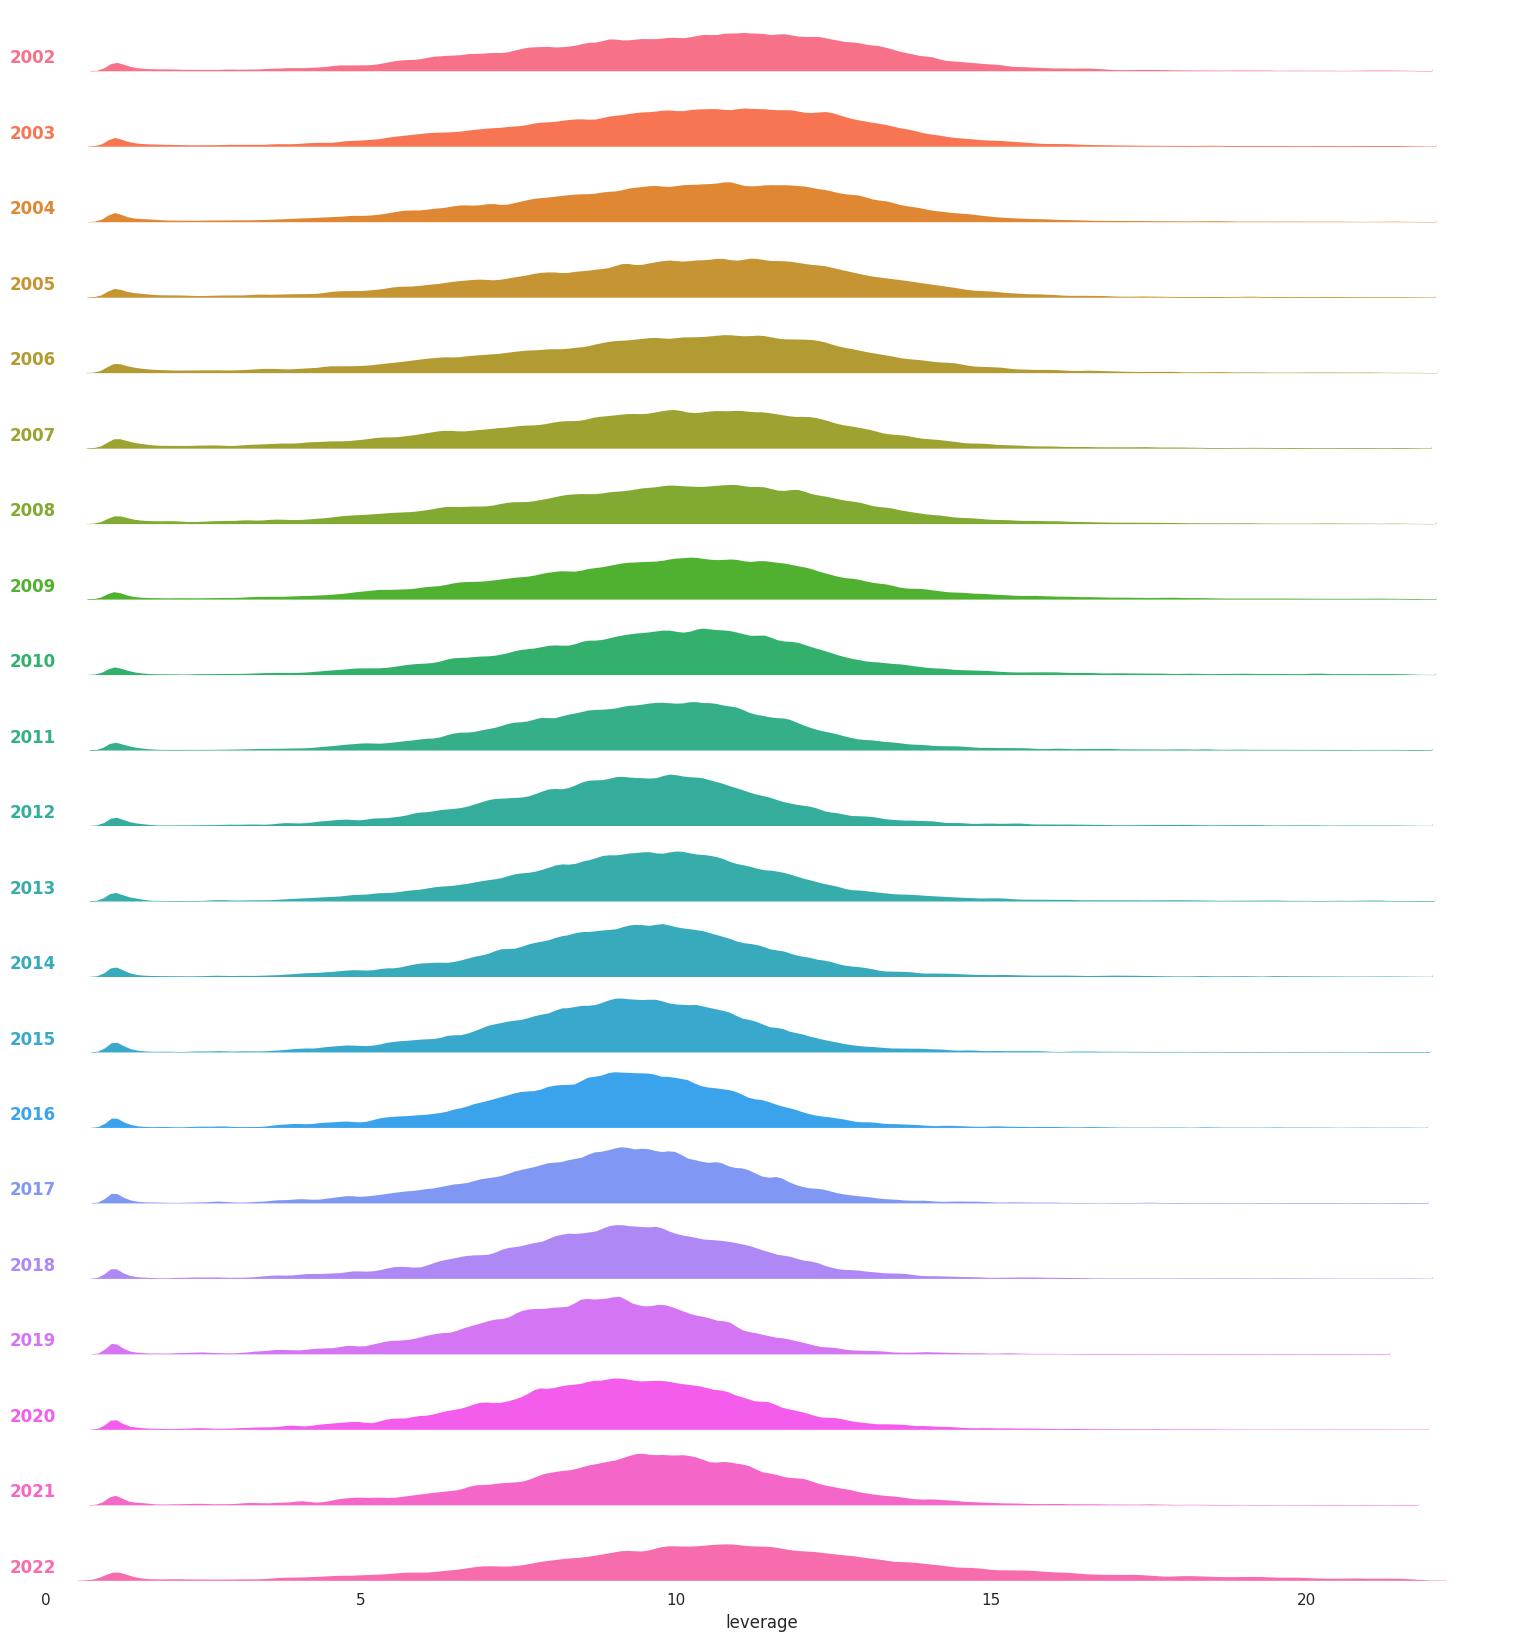

In [10]:
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
g = sns.FacetGrid(varYear, row="year", hue="year", aspect=20, height=0.8)

# Draw the densities in a few steps
g.map(sns.kdeplot, "leverage",
      bw_adjust=.3, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "leverage", clip_on=False, color="w", lw=2, bw_adjust=.3)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "leverage")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()

In [11]:
varYear.groupby("year")["leverage"].describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2002,67656.0,10.142993,3.007230,1.000490,8.283624,10.385150,12.164367,21.691837
2003,33279.0,10.090159,2.976606,1.000604,8.291063,10.314051,12.083502,21.707058
2004,32659.0,10.020986,2.977088,1.000600,8.256361,10.258668,12.000223,21.706157
2005,32104.0,9.970246,3.028735,1.000753,8.157346,10.230837,11.961639,21.688034
2006,31704.0,9.842976,3.156593,1.000373,7.970665,10.112878,11.903112,21.712200
2007,31153.0,9.587514,3.097434,1.000690,7.760844,9.861944,11.632392,21.617682
2008,30524.0,9.714779,3.050636,1.000262,7.931855,9.954735,11.698856,21.696160
2009,29057.0,9.962737,2.996067,1.000074,8.189269,10.066609,11.723519,21.703970
2010,27722.0,9.887806,2.850125,1.000092,8.237345,9.945372,11.455930,21.703814


In [12]:
jpMorgan = varTable[varTable["bank"] == "JPMORGAN CHASE BANK, NATIONAL ASSOCIATION"].groupby("year").mean()
jpMorgan

,assets,equity,liabilities,deposit,lending,borrowing,leverage
year,,,,,,,
2004,1.616433e+09,8.064000e+07,1.452441e+09,5.177100e+08,31459000.0,1.541500e+07,20.045052
2005,1.625699e+09,8.404950e+07,1.454423e+09,5.363348e+08,29716750.0,9.046750e+06,19.348519
2006,1.799386e+09,9.119800e+07,1.613735e+09,6.184430e+08,28087750.0,1.053400e+07,19.742791
2007,1.974604e+09,1.013722e+08,1.768879e+09,6.948790e+08,18751750.0,1.650175e+07,19.478978
2008,1.575234e+09,1.180522e+08,1.456066e+09,9.182875e+08,8431500.0,1.939100e+07,13.305424
2009,2.751968e+09,1.292545e+08,2.491834e+09,9.851792e+08,13425750.0,1.100200e+07,21.291334
2010,2.637505e+09,1.284155e+08,2.380510e+09,9.984568e+08,288250.0,1.088700e+07,20.557805
2011,1.788146e+09,1.271920e+08,1.660774e+09,1.149762e+09,453000.0,8.387250e+06,14.059753
2012,1.850596e+09,1.395748e+08,1.710796e+09,1.196130e+09,415000.0,2.697000e+06,13.269163


In [13]:
varYear

,bank,date,assets,equity,liabilities,deposit,lending,borrowing,year,leverage
0,BANK OF HANCOCK COUNTY,2002-12-31,74327.0,12561.0,61766.0,61501.0,7808,0,2002,5.917284
1,FIRST COMMUNITY BANK XENIA-FLORA,2002-12-31,25737.0,3856.0,21881.0,20614.0,943,0,2002,6.674533
2,"MINEOLA COMMUNITY BANK, SSB",2002-12-31,132091.0,17188.0,114903.0,77842.0,4190,0,2002,7.685071
3,BISON STATE BANK,2002-12-31,8408.0,1248.0,7160.0,7054.0,33,0,2002,6.737179
4,PEOPLES BANK,2002-12-31,150496.0,16944.0,133552.0,132029.0,3990,0,2002,8.881964
...,...,...,...,...,...,...,...,...,...,...
14456,GENESIS BANK,2022-03-31,95052.0,43070.0,51982.0,43039.0,0,0,2022,2.206919
14457,WATERFALL BANK,2022-03-31,87152.0,42141.0,45011.0,44905.0,0,0,2022,2.068105
14458,ENTREBANK,2022-03-31,35261.0,33691.0,1570.0,1570.0,0,0,2022,1.046600
14459,LOCALITY BANK,2022-03-31,43775.0,36338.0,7437.0,6456.0,0,0,2022,1.204662


In [14]:
df = varYear[varYear.date == "2022-03-31"].groupby("bank").mean()
df = df.sort_values("equity", ascending = False).reset_index()
df

,bank,assets,equity,liabilities,deposit,lending,borrowing,year,leverage
0,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",3.476711e+09,299153000.0,3.177537e+09,2.635021e+09,0.0,620000.0,2022.0,11.621849
1,"BANK OF AMERICA, NATIONAL ASSOCIATION",2.513619e+09,229392000.0,2.284227e+09,2.150323e+09,0.0,0.0,2022.0,10.957745
2,"WELLS FARGO BANK, NATIONAL ASSOCIATION",1.764272e+09,165473000.0,1.598770e+09,1.518051e+09,86000.0,209000.0,2022.0,10.661993
3,"CITIBANK, N.A.",1.718008e+09,164175000.0,1.553232e+09,1.373373e+09,0.0,0.0,2022.0,10.464492
4,TRUIST BANK,5.310450e+08,60506000.0,4.705160e+08,4.392360e+08,0.0,0.0,2022.0,8.776733
...,...,...,...,...,...,...,...,...,...
4190,BANK OF STEINAUER,1.636000e+04,1279.0,1.508100e+04,1.507400e+04,2000.0,0.0,2022.0,12.791243
4191,STATE BANK OF BURRTON,1.310400e+04,1066.0,1.203800e+04,1.202600e+04,0.0,0.0,2022.0,12.292683
4192,WABASH SAVINGS BANK,1.021600e+04,772.0,9.444000e+03,9.433000e+03,0.0,0.0,2022.0,13.233161
4193,"WALTON STATE BANK, THE",1.232300e+04,761.0,1.156200e+04,1.145200e+04,2447.0,0.0,2022.0,16.193167


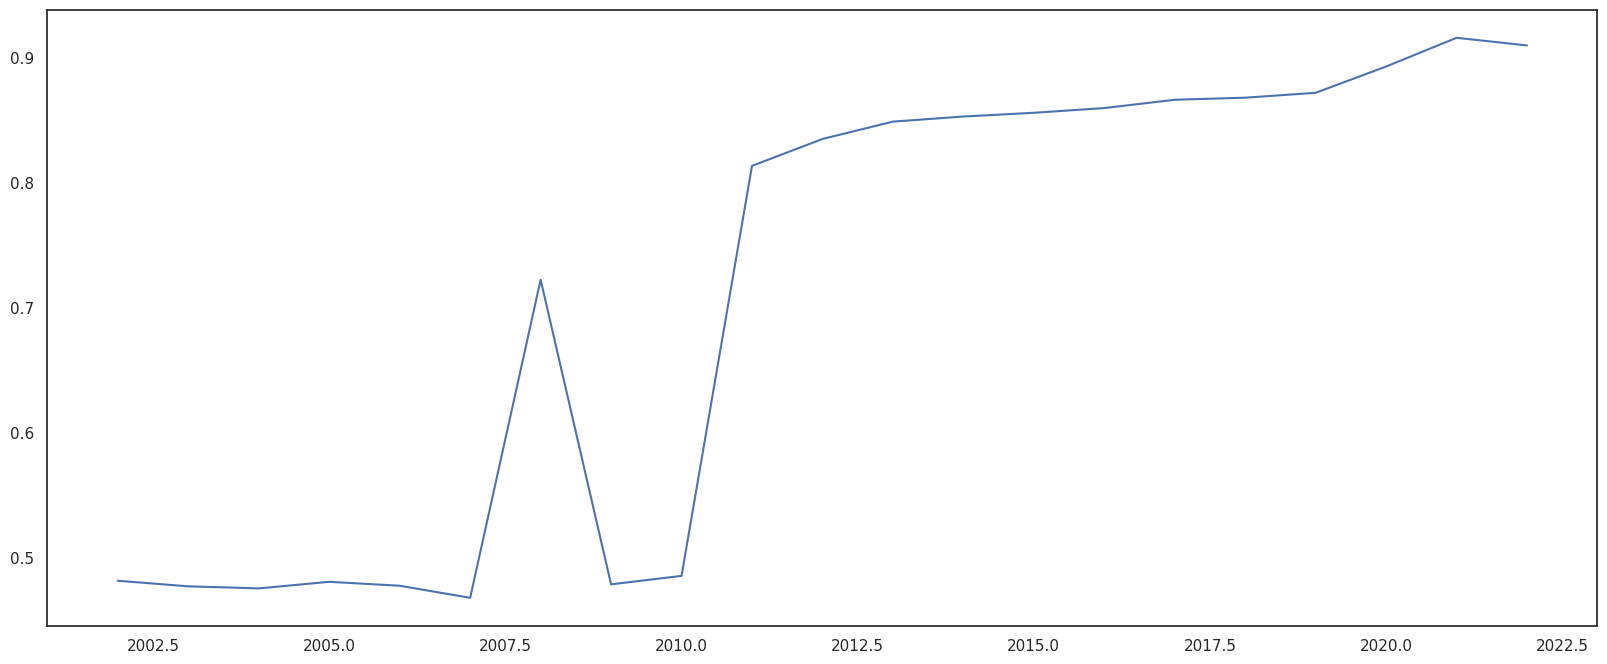

In [48]:
plt.plot(varTable.groupby("year")["deposit"].sum() / varTable.groupby("year")["liabilities"].sum(), label = "deposit/liabilities")